# DC-GAN - Prediction - Type 0 vs Type 1 - Diabetic Retinopathy

In [1]:
import os
import matplotlib
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.utils import np_utils
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import SGD,RMSprop,adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report

Using TensorFlow backend.


In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
trainLabels = pd.read_csv("trainLabels.csv")
trainLabels.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


## Data Loader

In [5]:
img_rows, img_cols = 200, 200

In [ ]:
listing_0 = os.listdir("dataset/dcgan_v3/train0/train_0")
listing_0 = listing_0[:700]

In [ ]:
immatrix = []
imlabel = []

with tqdm(listing_0) as pbar:
    for file in listing_0:
        base = os.path.basename("dataset/dcgan_v3/train0/train_0/" + file)
        fileName = os.path.splitext(base)[0]
        imlabel.append(0)
        im = Image.open("dataset/dcgan_v3/train0/train_0/" + file)   
        img = im.resize((img_rows,img_cols))
        gray = img.convert('L')
        immatrix.append(np.array(gray).flatten())
        pbar.update(1)

In [ ]:
listing_1 = os.listdir("dataset/dcgan_v3/train1/train_1/")
listing_1 = listing_1[:700]

In [ ]:
with tqdm(listing_1) as pbar:
    for file in listing_1:
        base = os.path.basename("dataset/dcgan_v3/train1/train_1/" + file)
        fileName = os.path.splitext(base)[0]
        imlabel.append(1)
        im = Image.open("dataset/dcgan_v3/train1/train_1/" + file)   
        img = im.resize((img_rows,img_cols))
        gray = img.convert('L')
        immatrix.append(np.array(gray).flatten())
        pbar.update(1)

immatrix = np.asarray(immatrix)
imlabel = np.asarray(imlabel)

In [ ]:
np.save('matrices/immatrix_4_01.npy', immatrix)
np.save('matrices/imlabel_4_01.npy', imlabel)

In [6]:
immatrix = np.load('matrices/immatrix_4_01.npy')
imlabel = np.load('matrices/imlabel_4_01.npy')

## Data Preprocessing

In [7]:
data,Label = shuffle(immatrix,imlabel, random_state=2)
train_data = [data,Label]

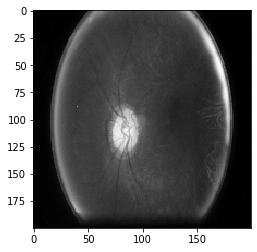

In [8]:
img=immatrix[167].reshape(img_rows,img_cols)
plt.imshow(img)
plt.imshow(img,cmap='gray')

In [9]:
batch_size = 8
nb_classes = 2
nb_epoch = 50
nb_filters = 32
nb_pool = 2
nb_conv = 3

(X, y) = (train_data[0],train_data[1])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

print(X_train.shape)
print(X_test.shape)

X_train = X_train.reshape(X_train.shape[0], img_cols, img_rows, 1)
X_test = X_test.reshape(X_test.shape[0], img_cols, img_rows, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

(1120, 40000)
(280, 40000)
X_train shape: (1120, 200, 200, 1)
1120 train samples
280 test samples


In [11]:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## CNN Model Definition

In [12]:
model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(img_cols, img_rows, 1)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(200, 200,..., padding="valid")`
  """
/raid/mlcysec19/software/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  


In [13]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 196, 196, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 196, 196, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 98, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 307328)           

### Data Augmentation

In [14]:
validationdatagenerator = ImageDataGenerator()
traindatagenerator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=15,zoom_range=0.1 )

train_generator=traindatagenerator.flow(X_train, Y_train, batch_size=batch_size) 
validation_generator=validationdatagenerator.flow(X_test, Y_test,batch_size=batch_size)

## Training

In [15]:
model.fit_generator(train_generator, verbose=1, steps_per_epoch=int(len(X_train)/batch_size), epochs=nb_epoch, validation_data=validation_generator, validation_steps=int(len(X_test)/batch_size))

Epoch 1/50
140/140 [==============================] - 123s 879ms/step - loss: 0.7460 - accuracy: 0.4964 - val_loss: 0.7010 - val_accuracy: 0.5143
Epoch 2/50
140/140 [==============================] - 120s 859ms/step - loss: 0.7093 - accuracy: 0.4973 - val_loss: 0.6865 - val_accuracy: 0.5429
Epoch 3/50
140/140 [==============================] - 111s 793ms/step - loss: 0.6961 - accuracy: 0.5063 - val_loss: 0.6830 - val_accuracy: 0.5250
Epoch 4/50
140/140 [==============================] - 111s 790ms/step - loss: 0.6957 - accuracy: 0.5348 - val_loss: 0.6981 - val_accuracy: 0.5429
Epoch 5/50
140/140 [==============================] - 116s 826ms/step - loss: 0.6946 - accuracy: 0.5268 - val_loss: 0.7254 - val_accuracy: 0.5429
Epoch 6/50
140/140 [==============================] - 110s 783ms/step - loss: 0.6948 - accuracy: 0.4929 - val_loss: 0.6946 - val_accuracy: 0.5714
Epoch 7/50
140/140 [==============================] - 109s 776ms/step - loss: 0.6929 - accuracy: 0.5411 - val_loss: 0.6932 -

In [ ]:
model.save("model_original_8_50_0vs1.h5")
print("Saved model to disk")

In [ ]:
model = load_model('model_original_8_50_0vs1.h5')
model.trainable=False

## Evaluation - Model Loss & Accuracy

In [16]:
scores = model.evaluate(X_test, Y_test)
print(scores)

280/280 [==============================] - 1s 5ms/step
[0.6889364055224827, 0.5285714268684387]


### Confusion Matrix

In [17]:
y_pred = model.predict(X_test)

confusion_matrix(y_pred.argmax(axis=-1), Y_test.argmax(axis=-1))

array([[145, 129],
       [  3,   3]])

### Precision, Recall & F1 Score - Classification Report

In [18]:
print(classification_report(y_pred.argmax(axis=-1), Y_test.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.98      0.53      0.69       274
           1       0.02      0.50      0.04         6

    accuracy                           0.53       280
   macro avg       0.50      0.51      0.37       280
weighted avg       0.96      0.53      0.67       280



### Accuracy

In [19]:
print("Accuracy: ", np.mean(Y_test.argmax(axis=-1) == y_pred.argmax(axis=-1)) * 100)

Accuracy:  52.85714285714286


## Training

In [20]:
model.fit_generator(train_generator, verbose=1, steps_per_epoch=int(len(X_train)/batch_size), epochs=nb_epoch, validation_data=validation_generator, validation_steps=int(len(X_test)/batch_size))

Epoch 1/50
140/140 [==============================] - 110s 788ms/step - loss: 0.6918 - accuracy: 0.5366 - val_loss: 0.7093 - val_accuracy: 0.4714
Epoch 2/50
140/140 [==============================] - 109s 776ms/step - loss: 0.6923 - accuracy: 0.5170 - val_loss: 0.7047 - val_accuracy: 0.4679
Epoch 3/50
140/140 [==============================] - 110s 789ms/step - loss: 0.6946 - accuracy: 0.5134 - val_loss: 0.7011 - val_accuracy: 0.4679
Epoch 4/50
140/140 [==============================] - 110s 789ms/step - loss: 0.6998 - accuracy: 0.5098 - val_loss: 0.7009 - val_accuracy: 0.4929
Epoch 5/50
140/140 [==============================] - 110s 783ms/step - loss: 0.6930 - accuracy: 0.5170 - val_loss: 0.6537 - val_accuracy: 0.4750
Epoch 6/50
140/140 [==============================] - 112s 798ms/step - loss: 0.6934 - accuracy: 0.5304 - val_loss: 0.6878 - val_accuracy: 0.5250
Epoch 7/50
140/140 [==============================] - 108s 769ms/step - loss: 0.6943 - accuracy: 0.5161 - val_loss: 0.7565 -

In [25]:
model.save("model_original_8_100_0vs1.h5")
print("Saved model to disk")

Saved model to disk


## Evaluation - Model Loss & Accuracy

In [21]:
scores = model.evaluate(X_test, Y_test)
print(scores)

280/280 [==============================] - 1s 2ms/step
[0.7074017388480051, 0.4714285731315613]


### Confusion Matrix

In [22]:
y_pred = model.predict(X_test)

confusion_matrix(y_pred.argmax(axis=-1), Y_test.argmax(axis=-1))

array([[  6,   6],
       [142, 126]])

### Precision, Recall & F1 Score - Classification Report

In [23]:
print(classification_report(y_pred.argmax(axis=-1), Y_test.argmax(axis=-1)))

              precision    recall  f1-score   support

           0       0.04      0.50      0.07        12
           1       0.95      0.47      0.63       268

    accuracy                           0.47       280
   macro avg       0.50      0.49      0.35       280
weighted avg       0.92      0.47      0.61       280



### Accuracy

In [24]:
print("Accuracy: ", np.mean(Y_test.argmax(axis=-1) == y_pred.argmax(axis=-1)) * 100)

Accuracy:  47.14285714285714
